In [1]:
from google.colab import files
uploaded = files.upload()

Saving api_data_aadhar_enrolment_0_500000.csv to api_data_aadhar_enrolment_0_500000 (1).csv
Saving api_data_aadhar_enrolment_500000_1000000.csv to api_data_aadhar_enrolment_500000_1000000 (1).csv
Saving api_data_aadhar_enrolment_1000000_1006029.csv to api_data_aadhar_enrolment_1000000_1006029 (1).csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

plt.rcParams["figure.figsize"] = (12, 6)
sns.set_style("whitegrid")

In [3]:
files_list = [
    "api_data_aadhar_enrolment_0_500000.csv",
    "api_data_aadhar_enrolment_500000_1000000.csv",
    "api_data_aadhar_enrolment_1000000_1006029.csv"
]

In [4]:
df = pd.concat(
    [pd.read_csv(f) for f in files_list],
    ignore_index=True
)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

Shape: (1006029, 7)
Columns: ['date', 'state', 'district', 'pincode', 'age_0_5', 'age_5_17', 'age_18_greater']


In [5]:
df["date"] = pd.to_datetime(
    df["date"],
    dayfirst=True,
    errors="coerce"
)

df["year_month"] = df["date"].dt.to_period("M")

In [6]:
df["total_enrolment"] = (
    df["age_0_5"]
    + df["age_5_17"]
    + df["age_18_greater"]
)

df["child_share"] = df["age_0_5"] / df["total_enrolment"]
df["school_age_share"] = df["age_5_17"] / df["total_enrolment"]
df["adult_share"] = df["age_18_greater"] / df["total_enrolment"]

df["dependency_ratio"] = (
    (df["age_0_5"] + df["age_5_17"])
    / df["age_18_greater"]
)

df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [7]:
monthly = (
    df
    .groupby("year_month")
    .agg({
        "total_enrolment": "sum",
        "age_0_5": "sum",
        "age_5_17": "sum",
        "age_18_greater": "sum"
    })
    .reset_index()
)

monthly["year_month"] = monthly["year_month"].astype(str)

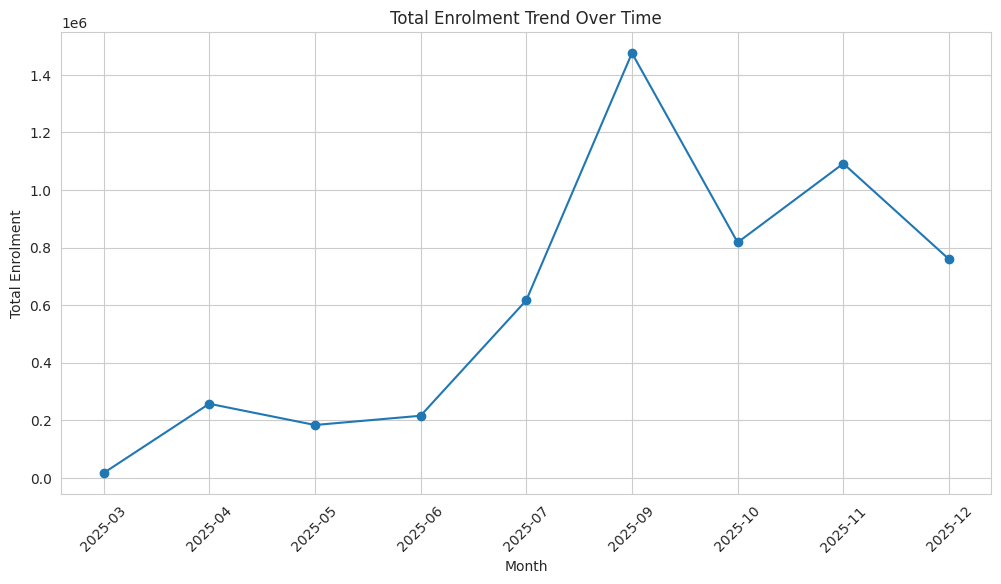

In [8]:
plt.plot(
    monthly["year_month"],
    monthly["total_enrolment"],
    marker="o"
)
plt.title("Total Enrolment Trend Over Time")
plt.xlabel("Month")
plt.ylabel("Total Enrolment")
plt.xticks(rotation=45)
plt.show()

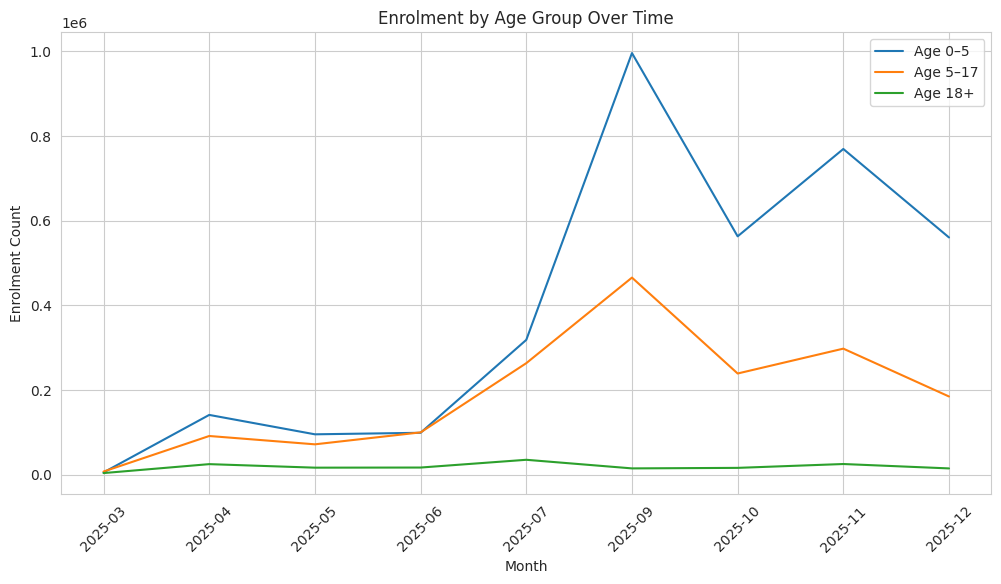

In [9]:
plt.plot(monthly["year_month"], monthly["age_0_5"], label="Age 0–5")
plt.plot(monthly["year_month"], monthly["age_5_17"], label="Age 5–17")
plt.plot(monthly["year_month"], monthly["age_18_greater"], label="Age 18+")
plt.title("Enrolment by Age Group Over Time")
plt.xlabel("Month")
plt.ylabel("Enrolment Count")
plt.legend()
plt.xticks(rotation=45)
plt.show()

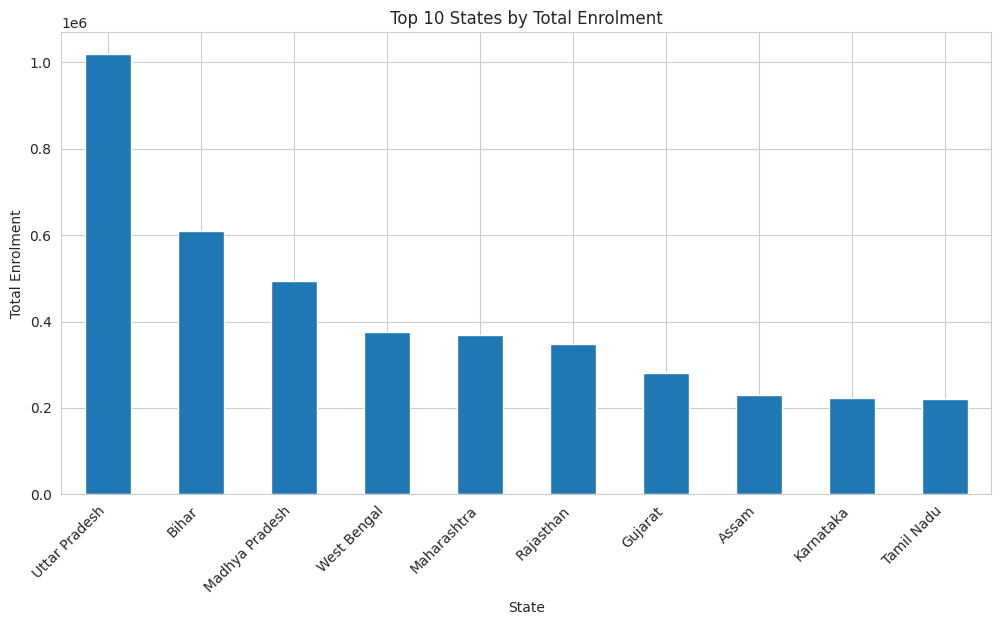

In [10]:
top_states = (
    df.groupby("state")["total_enrolment"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

top_states.plot(kind="bar")
plt.title("Top 10 States by Total Enrolment")
plt.xlabel("State")
plt.ylabel("Total Enrolment")
plt.xticks(rotation=45, ha="right")
plt.show()

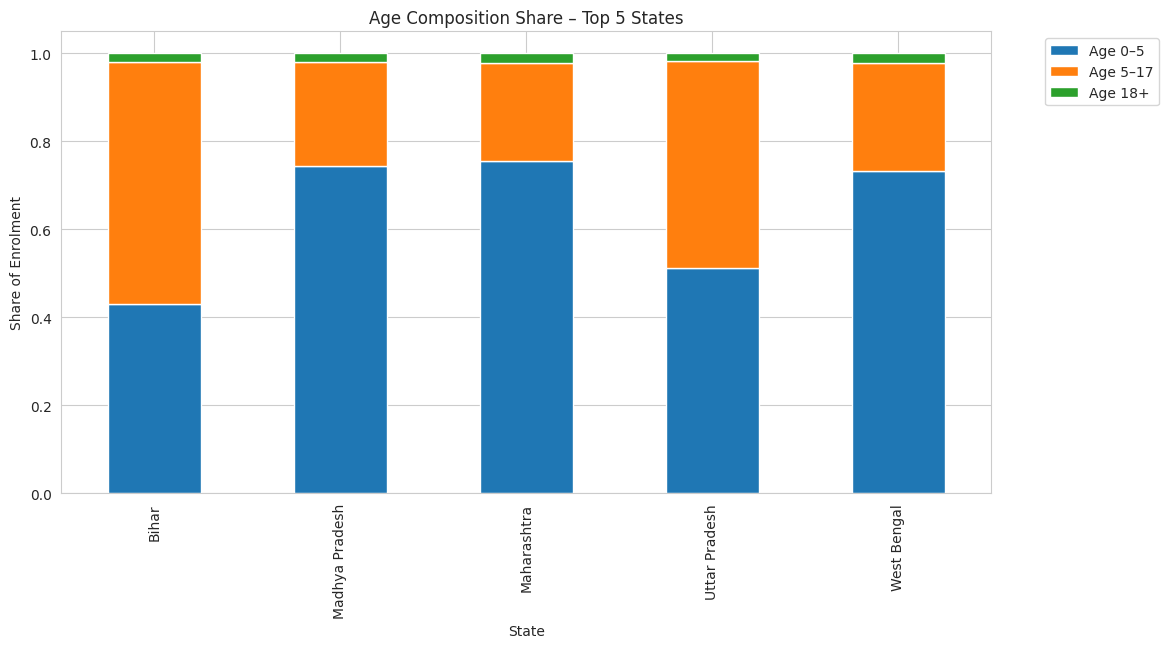

In [11]:
top5 = top_states.head(5).index

state_comp = (
    df[df["state"].isin(top5)]
    .groupby("state")[["age_0_5", "age_5_17", "age_18_greater"]]
    .sum()
)

state_comp_pct = state_comp.div(
    state_comp.sum(axis=1),
    axis=0
)

state_comp_pct.plot(
    kind="bar",
    stacked=True
)

plt.title("Age Composition Share – Top 5 States")
plt.xlabel("State")
plt.ylabel("Share of Enrolment")
plt.legend(
    ["Age 0–5", "Age 5–17", "Age 18+"],
    bbox_to_anchor=(1.05, 1)
)
plt.show()

In [12]:
state_monthly = (
    df
    .groupby(["state", "year_month"])
    .agg({
        "total_enrolment": "sum",
        "child_share": "mean",
        "school_age_share": "mean",
        "adult_share": "mean",
        "dependency_ratio": "mean"
    })
    .reset_index()
)

state_monthly = state_monthly.sort_values(["state", "year_month"])

state_monthly["enrolment_growth"] = (
    state_monthly
    .groupby("state")["total_enrolment"]
    .pct_change()
)

state_monthly["share_shift"] = (
    state_monthly
    .groupby("state")["school_age_share"]
    .diff()
    .abs()
)

In [13]:
ml_df = (
    state_monthly
    .groupby("state")
    .agg({
        "total_enrolment": "mean",
        "enrolment_growth": "mean",
        "child_share": "mean",
        "school_age_share": "mean",
        "adult_share": "mean",
        "dependency_ratio": "mean",
        "share_shift": "mean"
    })
    .dropna()
)

X = StandardScaler().fit_transform(ml_df)

kmeans = KMeans(n_clusters=3, random_state=42)
ml_df["cluster"] = kmeans.fit_predict(X)

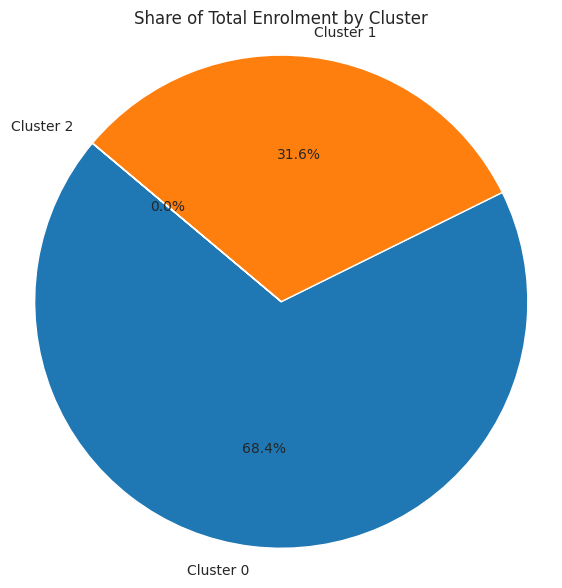

In [14]:
cluster_enrolment = (
    ml_df
    .groupby("cluster")["total_enrolment"]
    .sum()
)

plt.figure(figsize=(7, 7))
plt.pie(
    cluster_enrolment.values,
    labels=[f"Cluster {i}" for i in cluster_enrolment.index],
    autopct="%1.1f%%",
    startangle=140
)
plt.title("Share of Total Enrolment by Cluster")
plt.axis("equal")
plt.show()

In [15]:
print("\nState-wise Cluster Assignment:\n")
print(ml_df.sort_values("cluster"))


State-wise Cluster Assignment:

                                              total_enrolment  \
state                                                           
Andhra Pradesh                                   18240.142857   
Assam                                            25577.444444   
Chhattisgarh                                     11468.777778   
Chandigarh                                         544.600000   
Dadra and Nagar Haveli                             186.000000   
Goa                                                466.600000   
Delhi                                            10503.222222   
Dadra and Nagar Haveli and Daman and Diu            43.250000   
Haryana                                          10916.888889   
Himachal Pradesh                                  3497.200000   
Jammu and Kashmir                                 7998.500000   
Gujarat                                          31172.111111   
Jharkhand                                        19692.37

In [16]:
print("\nCluster-wise Characteristics:\n")
print(ml_df.groupby("cluster").mean())


Cluster-wise Characteristics:

         total_enrolment  enrolment_growth  child_share  school_age_share  \
cluster                                                                     
0           14299.898849          4.638075     0.729860          0.204620   
1           28282.350397          0.953968     0.388571          0.523104   
2              54.500000          8.573232     0.000000          0.250000   

         adult_share  dependency_ratio  share_shift  
cluster                                              
0           0.065520          9.321075     0.051017  
1           0.088325         12.573898     0.089778  
2           0.750000          0.000000     0.666667  
